## Analyse stylométrique de Tertullien: approche par le NLP

### Installation et importation des librairies

In [1]:
%%capture capt
#On aura besoin de la dernière version de Numpy
!pip install --upgrade numpy Interval
#On utilisera la librairie cltk (classical language toolkit) qui fait référence en NLP pour Python et pour les langues classiques
!pip install cltk
#Cela nous permettra de faire de beaux wordcloud 
!pip install wordcloud
#On utilisera la librairie cltk (natural language toolkit) qui fait référence en NLP pour Python et pour les langues contemporaines
!pip install nltk
!pip install pyLDAvis 
#Nous ferons aussi des modèles prédictifs : on utilisera Scikit-Learn
!pip install --upgrade scikit-learn
!pip install greek-accentuation

In [2]:
import wordcloud
import numpy as np
import io
import requests
import PIL
import matplotlib.pyplot as plt
import pandas as pd
import string
import re
from greek_accentuation.characters import base
from greek_accentuation.syllabify import *

### Nettoyage de notre texte

In [64]:
# Si on veut travailler avec le CSV mettre la valeur suivante à True:
Analyse_CSV=False
# Si on veut travailler avec le fichier .txt mettre la valeur suivante à True:
Analyse_TXT=True
text=''
# Suppression des stop-words à partir de ma propre base de stop-words
with open('StopwordsLatin.txt', 'r') as stop_words_file:
    stop_words = stop_words_file.read().splitlines()

In [65]:
## Nettoyage du texte
if Analyse_TXT:
    # Ouverture de mon fichier txt contenant le texte de Tertullien
    with open('Tert_Apol.txt', 'r', encoding="utf-8") as file:
        text = file.read()

    # Suppression de la ponctuation et réduction à la minuscule
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()

    # Suppression des nombres
    text = re.sub(r'\d+', '', text)

    # Tokenisation du texte
    words = text.split()
    
    #Suppresion des stop-words
    words = [word for word in words if word not in stop_words]

    # Création d'une variable texte pour la lisibilité humaine
    text = " ".join(words)

    # Enregistrement de ce texte nettoyé dans un nouveau fichier txt
    with open('Tert_Apol.txt', 'w', encoding="utf-8") as file:
        file.write(text)

    # # Enregistrement de la liste de mots nettoyée dans un nouveau fichier txt
    # with open('FJ_I-IV_lemm_mots_clean.txt', 'w', encoding="utf-8") as file:
    #     file.write(words)

In [66]:
if Analyse_TXT:
    #Exemple des 10 premiers mots
    print(words[:10])

['licet', 'vobis', 'romani', 'imperii', 'antistites', 'aperto', 'edito', 'ipso', 'fere', 'vertice']


In [67]:
if Analyse_TXT:
    #Si on ne veut garder que 1/7ème du texte, décommenter cette ligne
    #text=text[:len(text) // 7]
    #On affiche la longueur du texte
    print(len(text))  
    #Exemple de la variable texte
    print(text[:500])

120464
licet vobis romani imperii antistites aperto edito ipso fere vertice civitatis praesidentibus iudicandum palam dispicere coram examinare quid sit liquido causa christianorum hanc solam speciem auctoritas vestra iustitiae diligentia publico timet erubescit inquirere denique proxime accidit domesticis iudiciis nimis operata infestatio sectae huius obstruit defensioni liceat veritati occulta via tacitarum litterarum aures vestras pervenire nihil causa sua deprecatur condicione miratur scit se pereg


## Import CSV

In [68]:
if Analyse_CSV:
    #On ouvre le fichier CSV avec la librairie Pandas en précisant le séparateur
    CSV=pd.read_csv('De_Pallio.csv', sep=';')
    #On affiche le haut du dataframe
    CSV.head()

In [69]:
if Analyse_CSV:
    #On initialise le texte comme un texte vide
    text_csv=''
    #Pour chaque ligne du dataframe, on met en minuscule le mot de la colonne "lemma"
    for word in CSV['lemma'].apply(lambda x: x.lower()):
        #Si ce mot n'est pas un stop-words
        if word not in stop_words:
            #On l'ajoute à notre variable texte
            text_csv+=word + ' '
    #On enlève enfin la ponctuation
    text_csv = text_csv.translate(str.maketrans('', '', string.punctuation))
    #On affiche les 500 premiers caractères
    print(text_csv[:500])

In [70]:
if Analyse_CSV:
    #Si on ne veut garder que 1/7ème du texte, décommenter la ligne d'après
    #Cela diminue drastiquement le temps d'analyse de CLTK (voir cellules ci-dessous)
    #text=text_csv[:len(text_csv) // 7]
    text=text_csv

In [71]:
#On affiche les 500 premiers caractères
text[:500]

'licet vobis romani imperii antistites aperto edito ipso fere vertice civitatis praesidentibus iudicandum palam dispicere coram examinare quid sit liquido causa christianorum hanc solam speciem auctoritas vestra iustitiae diligentia publico timet erubescit inquirere denique proxime accidit domesticis iudiciis nimis operata infestatio sectae huius obstruit defensioni liceat veritati occulta via tacitarum litterarum aures vestras pervenire nihil causa sua deprecatur condicione miratur scit se pereg'

## Modèle de Classification

### Importation des librairies

In [3]:
%%capture capt
!pip install spacy 
!pip install gensim
!pip install sentence_transformers

In [4]:
from collections import Counter
import seaborn as sns
import gensim

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score

from gensim.models.word2vec import Word2Vec
import gensim.downloader
from sentence_transformers import SentenceTransformer

D:\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### On fait une analyse à partir du fichier txt puis on initialise la liste des stop-words

In [412]:
Analyse_TXT=True
with open('StopwordsLatin.txt', 'r') as stop_words_file:
    stop_words = stop_words_file.read().splitlines()

### Preprocessing des différents textes

In [414]:
if Analyse_TXT:
    # Ouverture de mon fichier txt contenant le texte Apologeticum
    with open('Apuleius_Flo.txt', 'r', encoding="utf-8") as file:
        text_apu = file.read()

    # Suppression de la ponctuation et réduction à la minuscule
    text_apu = text_apu.translate(str.maketrans('', '', string.punctuation))
    text_apu = text_apu.lower()

    # Suppression des nombres
    text_apu = re.sub(r'\d+', '', text_apu)

    # Tokenisation du texte
    words = text_apu.split()

    words = [word for word in words if word not in stop_words]

    # Création d'une variable texte pour la lisibilité humaine
    text_apu = " ".join(words)

    # Enregistrement de ce texte nettoyé dans un nouveau fichier txt
    with open('Apuleius_Flo_clean.txt', 'w', encoding="utf-8") as file:
        file.write(text_apu)

    # Enregistrement de la liste de mots nettoyée dans un nouveau fichier txt
    with open('Apuleius_Flo_mots_clean.txt', 'w', encoding="utf-8") as file:
        file.write('\n'.join(words))

In [415]:
if Analyse_TXT:
    # Ouverture de mon fichier txt contenant le texte De_Pallio
    with open('Cic_Pro_Milone.txt', 'r', encoding="utf-8") as file:
        text_ciceron= file.read()

    # Suppression de la ponctuation et réduction à la minuscule
    text_ciceron = text_ciceron.translate(str.maketrans('', '', string.punctuation))
    text_ciceron = text_ciceron.lower()

    # Suppression des nombres
    text_ciceron = re.sub(r'\d+', '', text_ciceron)

    # Tokenisation du texte
    words = text_ciceron.split()

    words = [word for word in words if word not in stop_words]

    # Création d'une variable texte pour la lisibilité humaine
    text_ciceron = " ".join(words)

    # Enregistrement de ce texte nettoyé dans un nouveau fichier txt
    with open('Cic_Pro_Milone_clean.txt', 'w', encoding="utf-8") as file:
        file.write(text_ciceron)

    # Enregistrement de la liste de mots nettoyée dans un nouveau fichier txt
    with open('Cic_Pro_Milone_mots_clean.txt', 'w', encoding="utf-8") as file:
        file.write('\n'.join(words))

In [416]:
if Analyse_TXT:
    # Ouverture de mon fichier txt contenant le texte Ciceron
    with open('De_Pallio.txt', 'r', encoding="utf-8") as file:
        text_de_pallio = file.read()

    # Suppression de la ponctuation et réduction à la minuscule
    text_de_pallio = text_de_pallio.translate(str.maketrans('', '', string.punctuation))
    text_de_pallio = text_de_pallio.lower()

    # Suppression des nombres
    text_de_pallio = re.sub(r'\d+', '', text_de_pallio)

    # Tokenisation du texte
    words = text_de_pallio.split()

    words = [word for word in words if word not in stop_words]

    # Création d'une variable texte pour la lisibilité humaine
    text_de_pallio = " ".join(words)

    # Enregistrement de ce texte nettoyé dans un nouveau fichier txt
    with open('De_Pallio_clean.txt', 'w', encoding="utf-8") as file:
        file.write(text_de_pallio)

    # Enregistrement de la liste de mots nettoyée dans un nouveau fichier txt
    with open('De_Pallio_mots_clean.txt', 'w' ,encoding="utf-8") as file:
        file.write('\n'.join(words))

In [417]:
if Analyse_TXT:
    # Ouverture de mon fichier txt contenant le texte Ciceron
    with open('Tert_Apol.txt', 'r', encoding="utf-8") as file:
        text_apol = file.read()

    # Suppression de la ponctuation et réduction à la minuscule
    text_apol = text_apol.translate(str.maketrans('', '', string.punctuation))
    text_apol = text_apol.lower()

    # Suppression des nombres
    text_apol = re.sub(r'\d+', '', text_de_pallio)

    # Tokenisation du texte
    words = text_apol.split()

    words = [word for word in words if word not in stop_words]

    # Création d'une variable texte pour la lisibilité humaine
    text_apol = " ".join(words)

    # Enregistrement de ce texte nettoyé dans un nouveau fichier txt
    with open('Tert_Apol_clean.txt', 'w', encoding="utf-8") as file:
        file.write(text_apol)

    # Enregistrement de la liste de mots nettoyée dans un nouveau fichier txt
    with open('Tert_Apol_mots_clean.txt', 'w' ,encoding="utf-8") as file:
        file.write('\n'.join(words))

### On coupe le texte en un nombre voulu de séquences 

In [451]:
from textwrap import wrap

#On définit le nombre de sequences voulu
Nb_sequences=100

#On crée des listes contenant des extraits de texte
phrases_apu=wrap(text_apu, len(text_apu)/Nb_sequences)
phrases_ciceron=wrap(text_ciceron, len(text_ciceron)/Nb_sequences)
phrases_de_pallio=wrap(text_de_pallio, len(text_de_pallio)/Nb_sequences)
phrases_apol=wrap(text_apol, len(text_apol)/Nb_sequences)

#On crée une liste qui contient le nom de l'auteur des extraits en question
auteur=np.array(['Apulée']*(Nb_sequences+1))
auteur=np.append(auteur,np.array(['Cicéron']*(Nb_sequences+1)))
auteur=np.append(auteur,np.array(['Tertullien_pallio']*(Nb_sequences+1)))
auteur=np.append(auteur,np.array(['Tertullien_apologeticum']*(Nb_sequences+1)))

### On réunit tout ça dans un dataframe Pandas

In [452]:
d = {'text': phrases_apu + phrases_ciceron+ phrases_de_pallio + phrases_apol, 'author': auteur}
spooky_df=pd.DataFrame(d)
#On affiche le haut du dataframe
spooky_df

,text,author
0,ut ferme religiosis uiantium moris est cum ali...,Apulée
1,umigatus uel lapis unguine delibutus parua hae...,Apulée
2,homines conuerterat pluris est auritus testis ...,Apulée
3,spatium qua pluitur et ninguitur ultra quod ca...,Apulée
4,pecua simul montibus feras simul homines urbib...,Apulée
...,...,...
399,suasisti medicamine sapientissimo verum etsi e...,Tertullien_apologeticum
400,vitia suffundo quis non aemulum suum cum videt...,Tertullien_apologeticum
401,sola mecum est habeo et alias artes in publico...,Tertullien_apologeticum
402,pulsat et qui stellarem coniectat et qui volat...,Tertullien_apologeticum


In [453]:
#Exemple du text de la première sequence
spooky_df['text'][0][:500]

'ut ferme religiosis uiantium moris est cum aliqui lucus aut aliqui locus sanctus in uia oblatus est uotum postulare pomum adponere paulisper adsidere ita mihi ingresso sanctissimam istam ciuitatem quanquam oppido festine m praefanda uenia et habenda oratio et inhibenda properatio est neque enim iustius religiosam moram uiatori obiecerit aut ara floribus redimita aut spelunca frondibus inumbrata aut quercus cornibus onerata aut fagus pellibus coronata uel enim colliculus sepimine consecratus uel '

### Encodage de la variable à prédire

In [454]:
le = LabelEncoder()
spooky_df['author_encoded'] = le.fit_transform(spooky_df['author'])

#### On fait une cross-validation pour éviter l'over-fitting et mesurer la performance de nos modèles

In [455]:
#On répartit 80% du jeu de données pour apprendre (phase d'entrainement "train phase") et 20% de ce même jeu de données pour comparer et évaluer nos prédictions (phase d'évaluation "test phase")
X_train, X_test, y_train, y_test = train_test_split(spooky_df['text'].values, 
                                                    spooky_df['author_encoded'].values, 
                                                    test_size=0.2, 
                                                    random_state=33,
                                                    stratify = spooky_df['author_encoded'].values)

In [456]:
#Nos labels à prédire
le.classes_

array(['Apulée', 'Cicéron', 'Tertullien_apologeticum',
       'Tertullien_pallio'], dtype=object)

In [457]:
print("Chiffre: label | Auteur")
print(y_train[0], le.inverse_transform([y_train[0]])[0])
print(y_train[1], le.inverse_transform([y_train[1]])[0])
print(y_train[3], le.inverse_transform([y_train[3]])[0])
print(y_train[2], le.inverse_transform([y_train[2]])[0])

Chiffre: label | Auteur
1 Cicéron
3 Tertullien_pallio
1 Cicéron
0 Apulée


In [458]:
print("Proportion de l'auteur encodé 0 (=Apulée)")
print("Dans le train")
print(100*y_train.tolist().count(0)/(len(y_train)))
print("Dans le test")
print(100*y_test.tolist().count(0)/(len(y_test)))

Proportion de l'auteur encodé 0 (=Apulée)
Dans le train
24.76780185758514
Dans le test
25.925925925925927


In [459]:
print("Proportion de l'auteur encodé 1 (=Cicéron)")
print("Dans le train")
print(100*y_train.tolist().count(1)/(len(y_train)))
print("Dans le test")
print(100*y_test.tolist().count(1)/(len(y_test)))

Proportion de l'auteur encodé 1 (=Cicéron)
Dans le train
25.077399380804952
Dans le test
24.691358024691358


In [460]:
print("Proportion de l'auteur encodé 2 (=Tertullien_apologeticum)")
print("Dans le train")
print(100*y_train.tolist().count(2)/(len(y_train)))
print("Dans le test")
print(100*y_test.tolist().count(2)/(len(y_test)))

Proportion de l'auteur encodé 2 (=Tertullien_apologeticum)
Dans le train
25.077399380804952
Dans le test
24.691358024691358


In [461]:
print("Proportion de l'auteur encodé 3 (=Tertullien_pallio)")
print("Dans le train")
print(100*y_train.tolist().count(3)/(len(y_train)))
print("Dans le test")
print(100*y_test.tolist().count(3)/(len(y_test)))

Proportion de l'auteur encodé 3 (=Tertullien_pallio)
Dans le train
25.077399380804952
Dans le test
24.691358024691358


En absolu dans une figure


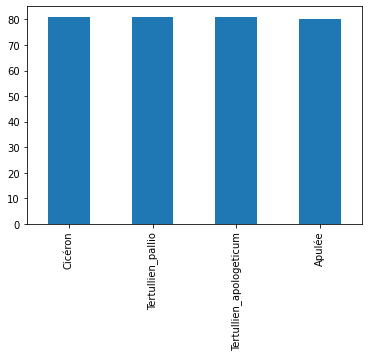

In [462]:
fig = pd.Series(le.inverse_transform(y_train)).value_counts().plot(kind='bar')
fig
print("En absolu dans une figure")

#### Mots les plus fréquents chez nos auteurs

In [463]:
# Suppression des stop words
X_train_no_sw = X_train

In [464]:
def plot_top_words(initials, ax, n_words=12):
    # Calcul des mots les plus fréquemment utilisés par l'auteur
    texts = X_train_no_sw[le.inverse_transform(y_train) == initials]
    all_tokens = ' '.join(texts).split()
    counts = Counter(all_tokens)
    top_words = [word[0] for word in counts.most_common(n_words)]
    top_words_counts = [word[1] for word in counts.most_common(n_words)]
    
    # Représentation sous forme de barplot
    ax = sns.barplot(ax = ax, x=top_words, y=top_words_counts)
    ax.set_title(f'Mots les plus fréquents chez {initials_to_author[initials]}')

In [ ]:
auteur

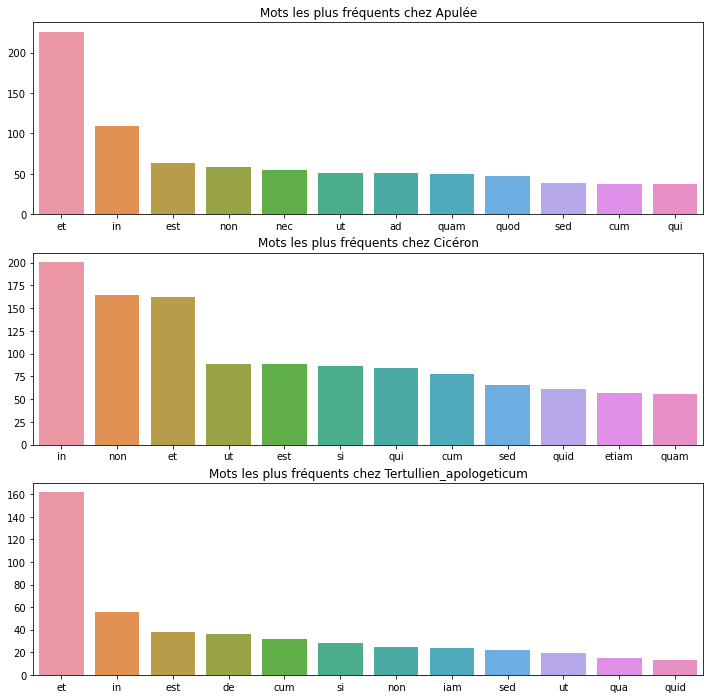

In [466]:
initials_to_author = {
    'Apulée': 'Apulée',
    'Cicéron': 'Cicéron',
    'Tertullien_pallio': 'Tertullien_pallio',
    'Tertullien_apologeticum': 'Tertullien_apologeticum'
}

fig, axs = plt.subplots(3, 1, figsize = (12,12))

plot_top_words('Apulée', ax = axs[0])
plot_top_words('Cicéron', ax = axs[1])
plot_top_words('Tertullien_pallio', ax = axs[2])
plot_top_words('Tertullien_apologeticum', ax = axs[2])
plt.savefig('Distribution_mots.png')

#### Prédiction sur l'échantillon de train

In [467]:
#Avec un modèle SVM linéaire
clf = LinearSVC(max_iter=10000, C=0.1)

##### Pipeline pour nos prédictions

In [468]:
def fit_vectorizers(vectorizer):
    pipeline = Pipeline(
    [
        ("vect", vectorizer()),
        ("scaling", StandardScaler(with_mean=False)),
        ("clf", clf),
    ]
    )

    parameters = {
        "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
        "vect__stop_words": ("english", None)
    }

    grid_search = GridSearchCV(pipeline, parameters, scoring='f1_micro',
                               cv=4, n_jobs=4, verbose=1)
    grid_search.fit(X_train, y_train)

    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

    print(f"CV scores {grid_search.cv_results_['mean_test_score']}")
    print(f"Mean F1 {np.mean(grid_search.cv_results_['mean_test_score'])}")
    
    return grid_search

#### Approche bag-of-words

In [469]:
cv_bow = fit_vectorizers(CountVectorizer)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


D:\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


	vect__ngram_range: (1, 2)
	vect__stop_words: None
CV scores [0.53248457 0.53252315 0.53549383 0.53865741]
Mean F1 0.534789737654321


D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Avec TF-IDF

In [470]:
cv_tfidf = fit_vectorizers(TfidfVectorizer)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


D:\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


	vect__ngram_range: (1, 2)
	vect__stop_words: None
CV scores [0.53564815 0.53873457 0.54791667 0.54795525]
Mean F1 0.5425636574074074


D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Word2vec en moyenne

In [471]:
X_train_tokens = [text.split() for text in X_train]
w2v_model = Word2Vec(X_train_tokens, vector_size=200, window=5, 
                     min_count=1, workers=4)

In [472]:
def get_mean_vector(w2v_vectors, words):
    words = [word for word in words if word in w2v_vectors]
    if words:
        avg_vector = np.mean(w2v_vectors[words], axis=0)
    else:
        avg_vector = np.zeros_like(w2v_vectors['hi'])
    return avg_vector

def fit_w2v_avg(w2v_vectors):
    X_train_vectors = np.array([get_mean_vector(w2v_vectors, words)
                                for words in X_train_tokens])
    
    scores = cross_val_score(clf, X_train_vectors, y_train, 
                         cv=4, scoring='f1_micro', n_jobs=4)

    print(f"CV scores {scores}")
    print(f"Mean F1 {np.mean(scores)}")
    return scores

#### Commentaires: Faibles performances car corpus restreint pour le train nous-mêmes

In [473]:
cv_w2vec = fit_w2v_avg(w2v_model.wv)

CV scores [0.22222222 0.33333333 0.33333333 0.3375    ]
Mean F1 0.3065972222222222


#### Word2vec pré-entraîné que l'on importe

In [474]:
glove_model = gensim.downloader.load('glove-wiki-gigaword-200')

In [475]:
#Embedding de cum
glove_model['cum']

array([ 0.21934  , -0.10183  ,  0.3707   , -0.16501  ,  0.20127  ,
       -0.60198  ,  0.77885  ,  0.1856   , -0.73361  , -0.32784  ,
        0.22417  , -0.097371 ,  0.1805   , -0.20121  ,  0.55502  ,
       -0.070672 , -0.02783  , -0.5131   ,  0.47268  ,  0.0064764,
        0.47277  ,  0.7915   ,  1.2494   , -0.19072  ,  0.10339  ,
        0.052244 ,  0.10732  , -0.40319  ,  0.89649  , -0.70073  ,
        0.0051075,  0.22344  , -0.28853  ,  0.25397  ,  0.57387  ,
       -0.018046 ,  0.6021   , -0.070996 ,  0.35939  ,  0.55465  ,
        0.45364  ,  0.50275  , -0.81195  ,  0.68128  ,  0.1271   ,
       -0.19944  ,  0.42972  , -0.30237  ,  0.75661  , -0.40376  ,
        0.23321  ,  0.82629  , -0.087611 ,  0.011857 , -0.48896  ,
        0.13016  ,  0.36081  ,  0.31407  , -0.27588  , -0.70413  ,
       -0.12153  , -0.4248   , -0.13431  , -0.017087 ,  0.23467  ,
       -0.10985  ,  0.16929  , -0.15853  ,  0.2458   , -0.051831 ,
        0.15726  , -0.42345  ,  0.49877  , -0.051819 ,  0.1201

#### Commentaires: Bien meilleures performances avec importation d'un modèle déjà entrainé, wouah !

In [476]:
cv_w2vec_transfert = fit_w2v_avg(glove_model)

CV scores [0.45679012 0.41975309 0.4691358  0.4375    ]
Mean F1 0.4457947530864197


#### Tableau de nos métriques

In [477]:
perfs = pd.DataFrame(
    [np.mean(cv_bow.cv_results_['mean_test_score']),
     np.mean(cv_tfidf.cv_results_['mean_test_score']),
    np.mean(cv_w2vec),
    np.mean(cv_w2vec_transfert)],
    index = ['Bag-of-Words','TF-IDF', 'Word2Vec non pré-entraîné', 'Word2Vec pré-entraîné'],
    columns = ["Mean F1 score"]
).sort_values("Mean F1 score",ascending = False)
perfs

,Mean F1 score
TF-IDF,0.542564
Bag-of-Words,0.534790
Word2Vec pré-entraîné,0.445795
Word2Vec non pré-entraîné,0.306597


#### Contextual Embeddings

In [478]:
model = SentenceTransformer('all-mpnet-base-v2')

In [479]:
#On fit notre modèle avec nos valeurs
X_train_vectors = model.encode(X_train)

In [480]:
scores = cross_val_score(clf, X_train_vectors, y_train, 
                         cv=4, scoring='f1_micro', n_jobs=4)

print(f"CV scores {scores}")
print(f"Mean F1 {np.mean(scores)}")

CV scores [0.48148148 0.4691358  0.50617284 0.4       ]
Mean F1 0.46419753086419757


#### Tableau récapitulatif de nos métriques : c'est très encourageant !

In [481]:
perfs = pd.concat(
  [perfs,
  pd.DataFrame(
    [np.mean(scores)],
    index = ['Contextual Embedding'],
    columns = ["Mean F1 score"])]
).sort_values("Mean F1 score",ascending = False)
perfs

,Mean F1 score
TF-IDF,0.542564
Bag-of-Words,0.534790
Contextual Embedding,0.464198
Word2Vec pré-entraîné,0.445795
Word2Vec non pré-entraîné,0.306597


In [482]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-mpnet-base-v2')
emb1=model.encode("quem laberius reciprocicornem lanicutem testitrahum trabes machina muros frangere militat nemini unquam adhuc libratum illa dicitur carthago studiis asperrima belli prima omnium armasse oscillum penduli impetus commentata vim tormenti bile pecoris caput vindicantis ultimant tempora patriae aries romanus muros quodam suos audet s")
emb2=model.encode("Ich heisse Mathilde Schwoerer. Ich wohne in Elsass")
emb3=model.encode("Qui bene amat bene castigat")
emb4=model.encode("romani imperii antistites aperto edito ipso fere vertice civitatis praesidentibus iudicandum palam dispicere coram examinare sit liquido causa christianorum hanc solam speciem auctoritas vestra iustitiae diligentia publico timet erubescit inquirere denique proxime accidit domesticis iudiciis nimis operata infestatio sectae huius obstruit defensioni liceat veritati occulta via tacitarum litterarum aures vestras pervenire nihil causa sua deprecatur condicione miratur scit se peregrinam terris agere extraneos")

cos_sim = util.cos_sim(emb1, emb2)
print("Cosine-Similarity:", cos_sim)
cos_sim = util.cos_sim(emb1, emb3)
print("Cosine-Similarity:", cos_sim)
cos_sim = util.cos_sim(emb1, emb4)
print("Cosine-Similarity:", cos_sim)

Cosine-Similarity: tensor([[0.1019]])
Cosine-Similarity: tensor([[0.3219]])
Cosine-Similarity: tensor([[0.5429]])


In [450]:
#Modèle à chercher ici: https://huggingface.co/models?language=la
#Liste des modèles pre-train: https://www.sbert.net/docs/pretrained_models.html 

#Ce modèle a l'air pas mal mais il est lourd !
#model2 = SentenceTransformer('xlm-roberta-large')
# emb1=model2.encode("quem laberius reciprocicornem lanicutem testitrahum trabes machina muros frangere militat nemini unquam adhuc libratum illa dicitur carthago studiis asperrima belli prima omnium armasse oscillum penduli impetus commentata vim tormenti bile pecoris caput vindicantis ultimant tempora patriae aries romanus muros quodam suos audet s")
# emb2=model2.encode("Ich heisse Mathilde Schwoerer. Ich wohne in Elsass")
# emb3=model2.encode("Qui bene amant bene castigat")
# emb4=model2.encode("romani imperii antistites aperto edito ipso fere vertice civitatis praesidentibus iudicandum palam dispicere coram examinare sit liquido causa christianorum hanc solam speciem auctoritas vestra iustitiae diligentia publico timet erubescit inquirere denique proxime accidit domesticis iudiciis nimis operata infestatio sectae huius obstruit defensioni liceat veritati occulta via tacitarum litterarum aures vestras pervenire nihil causa sua deprecatur condicione miratur scit se peregrinam terris agere extraneos")

# cos_sim = util.cos_sim(emb1, emb2)
# print("Cosine-Similarity:", cos_sim)
# cos_sim = util.cos_sim(emb1, emb3)
# print("Cosine-Similarity:", cos_sim)
# cos_sim = util.cos_sim(emb1, emb4)
# print("Cosine-Similarity:", cos_sim)

In [410]:
#Train un modèle avec Tertullien ?
# C'est ici : https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/multilingual/make_multilingual.py

## Utilisation de CLTK pour faire de l'analyse de texte

In [14]:
#Importation de la librairie cltk
from cltk import NLP
#On indique que l'on va travailler en latin
cltk_nlp = NLP(language="lat")

#On enlève l'embedding (troisième élément de la liste en partant de la fin), cela demande trop d'espace en mémoire et ne sert pas à notre analyse
cltk_nlp.pipeline.processes.pop(-2)

# cltk_nlp.pipeline.processes.pop(-1)
# cltk_nlp.pipeline.processes.pop(-1)


D:\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


‎𐤀 CLTK version '1.1.6'.
Pipeline for language 'Latin' (ISO: 'lat'): `LatinNormalizeProcess`, `LatinStanzaProcess`, `LatinEmbeddingsProcess`, `StopsProcess`, `LatinLexiconProcess`.


cltk.stops.processes.StopsProcess

In [ ]:
#Lancement du pipeline d'analyse de texte : de là nous pouvons lemmatiser, retrouver la ponctuation etc...
%time cltk_doc = cltk_nlp.analyze(text=text)

In [72]:
#On construit une liste qui contient tous les mots lemmatisés en enlevant les stop-words
Deja_lemmatise=True
if not Deja_lemmatise:
    if Analyse_TXT:
        Lemme = [word for word in cltk_doc.lemmata[:] if word not in stop_words]
        print(Lemme[:10])
    if Analyse_CSV:
        Lemme = [word for word in CSV['lemma'].apply(lambda x: x.lower()) if word not in stop_words]
        print(Lemme[:10])
if Deja_lemmatise:
    Lemme= [word for word in words if word not in stop_words]

In [73]:
# On enregistre la liste de mots lemmatisés
with open('Mots_lemmatisés.txt', 'w', encoding="utf-8") as file:
    file.write('\n'.join(Lemme))

##  Réalisation du Wordcloud

In [ ]:
!pip install greek-accentuation
from greek_accentuation.characters import base
from greek_accentuation.syllabify import *

In [74]:
#On fabrique à nouveau le texte à partir des mots lemmatisés
Texte=''
if Analyse_TXT:
    #On fabrique à nouveau le texte à partir des mots lemmatisés
    Texte=''
    for mots in Lemme:
        Texte +=' ' + mots
    print(Texte[:500])
    with open('Texte_lemmatisé.txt', 'w', encoding="utf-8") as file:
        file.write(Texte)
if Analyse_CSV:
    Texte=text
    with open('Texte_lemmatisé.txt', 'w', encoding="utf-8") as file:
        file.write(Texte)

 licet vobis romani imperii antistites aperto edito ipso fere vertice civitatis praesidentibus iudicandum palam dispicere coram examinare quid sit liquido causa christianorum hanc solam speciem auctoritas vestra iustitiae diligentia publico timet erubescit inquirere denique proxime accidit domesticis iudiciis nimis operata infestatio sectae huius obstruit defensioni liceat veritati occulta via tacitarum litterarum aures vestras pervenire nihil causa sua deprecatur condicione miratur scit se pere


In [75]:
from nltk import FreqDist

# Création d'une distribution de la fréquence des mots
fdist = FreqDist(Lemme)

# On affiche les mots les plus fréquents ainsi que leurs fréquences
print(fdist.most_common(20))


[('esse', 86), ('dei', 69), ('deum', 60), ('quid', 59), ('deos', 52), ('vobis', 51), ('vos', 50), ('per', 49), ('apud', 48), ('tamen', 48), ('ita', 47), ('deo', 47), ('ne', 46), ('magis', 45), ('quibus', 45), ('quo', 41), ('sunt', 41), ('quis', 41), ('quos', 41), ('quoque', 40)]


In [76]:
#On crée des listes pour les futurs graphiques
Mots_courants= [fdist.most_common(20)[i][0] for i in range (20)]
Mots_courants

['esse',
 'dei',
 'deum',
 'quid',
 'deos',
 'vobis',
 'vos',
 'per',
 'apud',
 'tamen',
 'ita',
 'deo',
 'ne',
 'magis',
 'quibus',
 'quo',
 'sunt',
 'quis',
 'quos',
 'quoque']

In [77]:
#On crée des listes pour les futurs graphiques
Nb_itérations=[fdist.most_common(20)[i][1] for i in range (20)]
Nb_itérations

[86,
 69,
 60,
 59,
 52,
 51,
 50,
 49,
 48,
 48,
 47,
 47,
 46,
 45,
 45,
 41,
 41,
 41,
 41,
 40]

<function matplotlib.pyplot.show(close=None, block=None)>

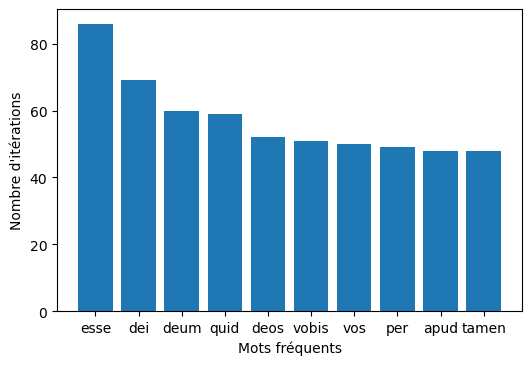

In [78]:
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 100
#On crée le graphique
plt.bar(Mots_courants[:10],Nb_itérations[:10])
plt.xlabel('Mots fréquents')
plt.ylabel(f"Nombre d'itérations")
plt.savefig('Distribution_Mots_Frequents.png', bbox_inches='tight')
plt.show

In [79]:
%%capture capt
#On cherche une image pour un beau rendu en s'étant renseigné sur des projets similaires
img = "https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/course/NLP/book.png"
book_mask = np.array(PIL.Image.open(io.BytesIO(requests.get(img).content)))

#On crée une figure
fig = plt.figure()
max_words=20
#On crée une fonction pour générer le wordcloud
def make_wordcloud(corpus):
    global d
    wc = wordcloud.WordCloud(background_color="white", max_words=max_words, mask=book_mask, contour_width=3, contour_color='steelblue')
    #wc.generate(corpus)
    d = {}
    for i in range(0,max_words):
        Mot=""
        for lettre in range(len(fdist.most_common(max_words)[i][0])):
            Mot+=base(fdist.most_common(max_words)[i][0][lettre])
        d.update({Mot : fdist.most_common(max_words)[i][1]})
    wc.generate_from_frequencies(d)
    return wc

plt.imshow(make_wordcloud(Texte), interpolation='bilinear')
plt.axis("off")
#plt.show()
plt.savefig('Wordcloud.png', bbox_inches='tight')

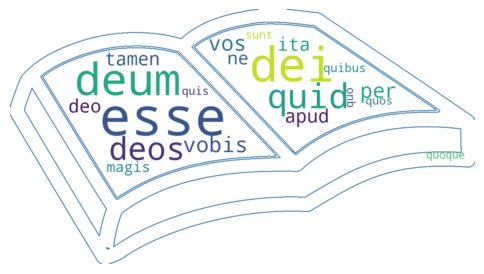

In [80]:
#On affiche notre wordcloud
from PIL import Image
im = Image.open('Wordcloud.png')
im

### Différentes caractéristiques sur notre texte

In [356]:
#On crée l'arbre de dépendance de nos mots
from cltk.dependency.tree import DependencyTree
a_tree_grc = DependencyTree.to_tree(cltk_doc.sentences[0][:56]) 

In [ ]:
#On affiche le texte et son arbre de dépendance correspondant
print(cltk_doc.sentences_strings[0][:399])
a_tree_grc.print_tree()

In [358]:
#On affiche toutes les caractéristiques que peut nous fournir cltk sur notre texte
from cltk.utils.feature_extraction import cltk_doc_to_features_table
feature_names, list_of_list_features = cltk_doc_to_features_table(cltk_doc=cltk_doc)
print(feature_names)

['string', 'lemma', 'embedding', 'is_stop', 'lemma', 'pos', 'case', 'gender', 'animacy', 'number', 'definiteness', 'degree', 'strength', 'verbform', 'tense', 'mood', 'aspect', 'voice', 'person', 'polarity', 'politeness', 'clusivity', 'evidentiality', 'strength', 'governing_word', 'governor_case', 'governor_gender', 'governor_animacy', 'governor_number', 'governor_definiteness', 'governor_degree', 'governor_strength', 'governor_verbform', 'governor_tense', 'governor_mood', 'governor_aspect', 'governor_voice', 'governor_person', 'governor_polarity', 'governor_politeness', 'governor_clusivity', 'governor_evidentiality', 'governor_strength', 'governing_relationship']


In [ ]:
#On affiche à titre d'exemple toutes les caractéristiques du mot "carthaginienses"
from pprint import pprint
# Putting these together for easier reading
pprint(list(zip(feature_names, list_of_list_features[4][:15])))

### LDA sur notre texte

In [81]:
#On réalise une LDA à partir de scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#On crée un dataframe Pandas qui contient une liste de nos mots lemmatisés
if not Deja_lemmatise:
    if Analyse_TXT:
        d = {'Tokens': cltk_doc.tokens[:]}
    if Analyse_CSV:
        d = {'Tokens': Lemme}
if Deja_lemmatise:
    d = {'Tokens': Lemme}
corpus=pd.DataFrame(data=d)

# Initialisation de notre vecteur de comptage avec mes propres stop-words
count_vectorizer = CountVectorizer(stop_words=stop_words)
count_data = count_vectorizer.fit_transform(corpus.apply(lambda s: ' '.join(s)))

# Hyperparamètres de notre LDA
number_topics = 5 #On prend 5 sujets
number_words = 100 #On prend 10 mots représentatifs

#On instance notre LDA
# avec n_components = nombres de sujets à extraire
lda = LatentDirichletAllocation(n_components=3, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0,
                                n_jobs = 1)
#On entraine notre modèle
lda.fit(count_data)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=3, n_jobs=1, random_state=0)

In [82]:
# On affiche les sujets retenus par notre LDA avec leurs mots représentatifs
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nSujet #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_topics(lda, count_vectorizer, number_words)


Sujet #0:
esse deum magis dei apud quos vos quis per quid plane se vobis deos quibus tamen ergo nunc homo christianus ipsi ita denique quidem deo nisi suis tam sunt quo quem ille deorum haec qua ideo post quoque ne eius cur causa utique ante religionis derivantes sub sine vestris vino saeculo fidem ipsius unde honorem omnia eadem suo stetit modum licet saevitiam aeque tantum leges imperatoris sui falsa nam christianorum noctem retro sumus deprehendemini minerva quaeque tunc homines eum nobis vestros corpus eiusmodi nihil toros cultores timere hostes nostra orbis semper christianos hanc occupaverunt iure dum adeo lupercos parum gratias

Sujet #1:
esse dei quid deum deos vobis vos per tamen apud deo ne ita quibus magis sunt quo quis quoque quos utique neque quem eius deus quidem se nisi qua nunc ergo nobis haec sit christianus nihil tam ipsi nam id vero illis licet ante igitur nomen illi eo cur christiani sine christianorum denique dum sub omnia homines vestris atque sibi semper an illo

In [83]:
#On en fait des wordcloud pour mieux voir ce qu'il se passe
from wordcloud import WordCloud
tf_feature_names = count_vectorizer.get_feature_names_out()

def wordcloud_lda(lda, tf_feature_names):
    fig, axs = plt.subplots(len(lda.components_) // 3 + 1, 3)
    for i in range(len(lda.components_)):
        corpus_lda = lda.components_[i]
        first_topic_words = [tf_feature_names[l] for l in corpus_lda.argsort()[:-50-1:-1]]
        k = i // 3
        j = (i - k*3)
        wordcloud = WordCloud(stopwords=stop_words, background_color="black",width = 2500, height = 1800)
        wordcloud = wordcloud.generate(" ".join(first_topic_words))
        axs[k][j].set_title("Wordcloud pour le \nsujet {}".format(i))
        axs[k][j].axis('off')
        axs[k][j].imshow(wordcloud)
        plt.savefig('Dirichlet.png',dpi=300)
        
  
    r = len(lda.components_) % 3
    [fig.delaxes(axs[len(lda.components_) // 3,k-1]) for k in range(r+1, 3+1) if r != 0]


In [84]:
%%capture capt
wc = wordcloud_lda(lda, tf_feature_names)

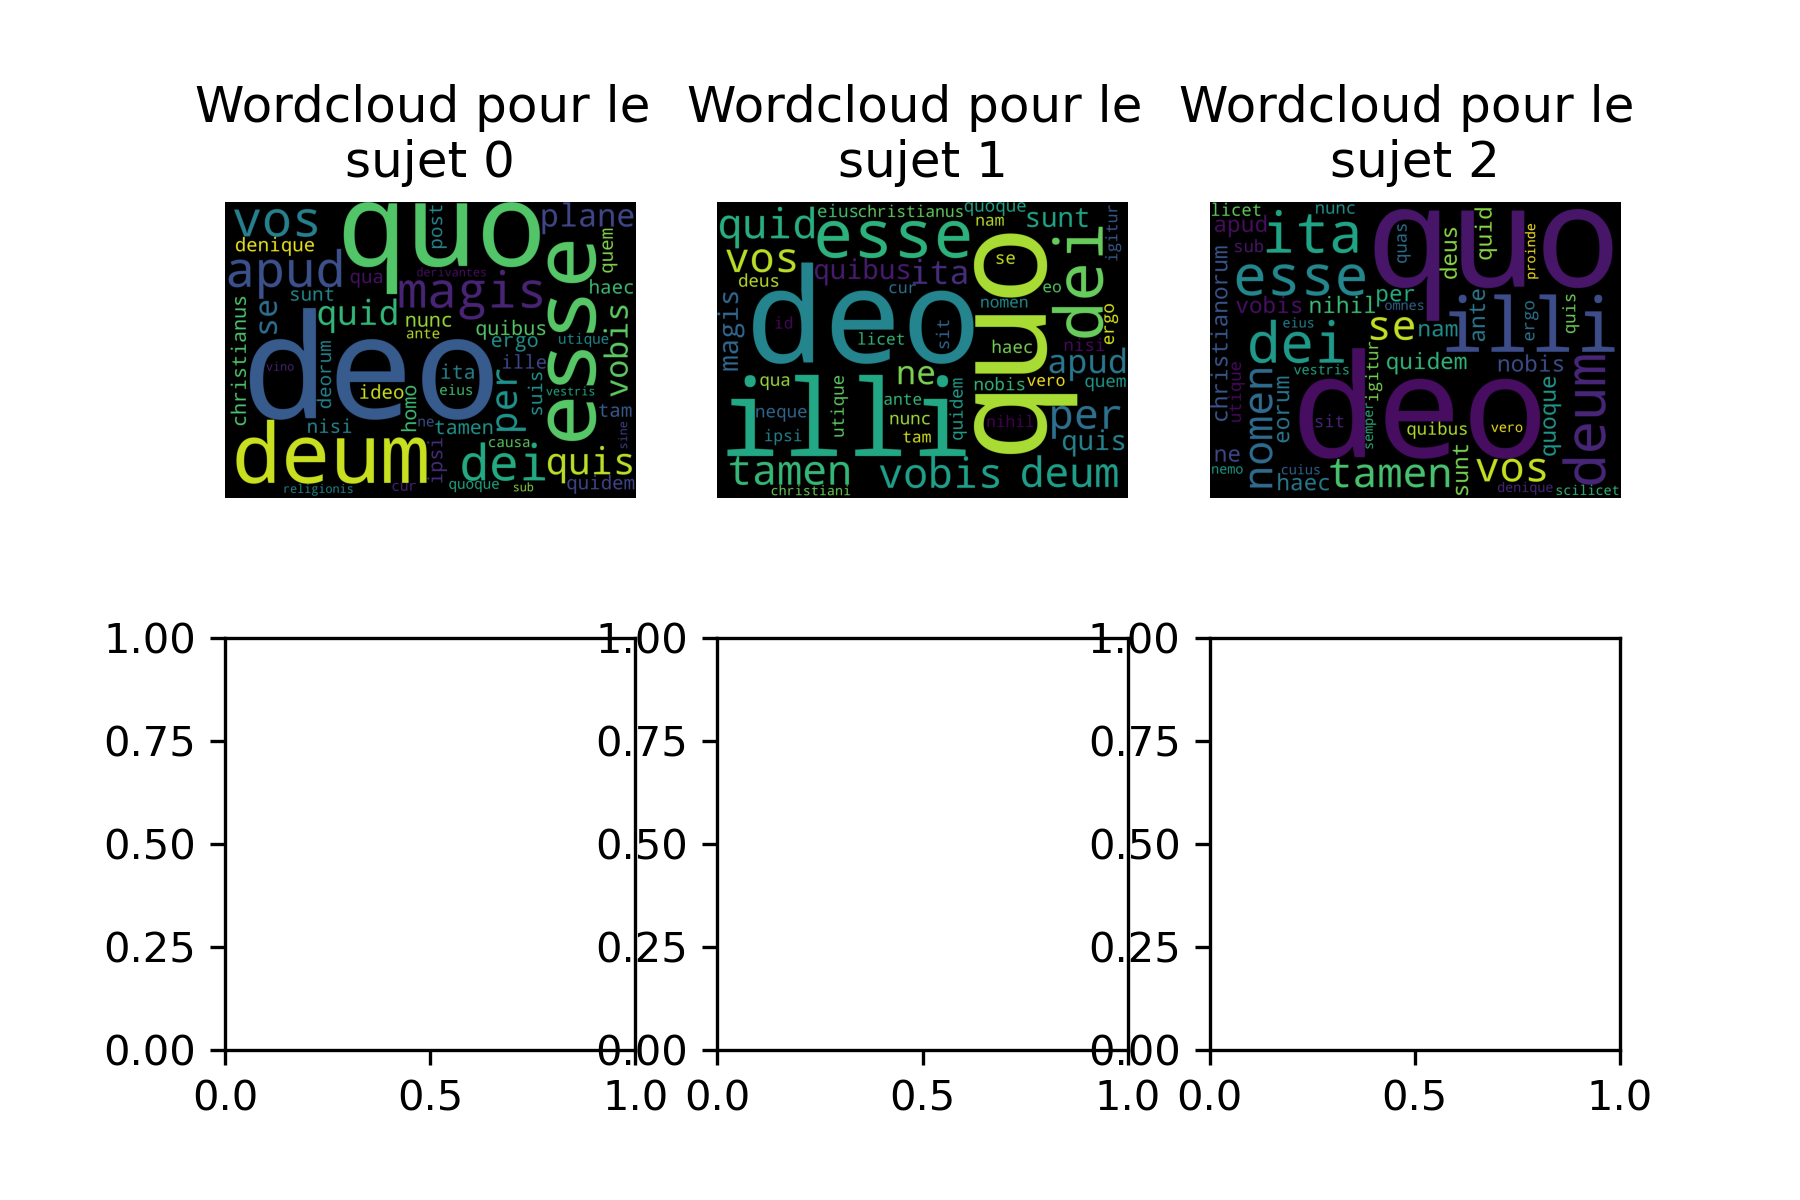

In [85]:
#On affiche le rendu
im = Image.open('Dirichlet.png')
im

In [ ]:
#On essaie une autre visualisation qui ne marche pas
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
vis_data = pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer, n_jobs = 3)
pyLDAvis.display(vis_data)